In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.nn import MSELoss
from torch.optim import Adam
import torch.nn.functional as nnf
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import Dataset

from torchvision.transforms import transforms, Resize
import torchvision.datasets as datasets

from torchinfo import summary

from utils.datasets import CIFAR_SR_completion

from tqdm import tqdm

import matplotlib.pyplot as plt

from models.completion.HVAE import HVAE

from utils.metrics import validation_scores

from piq import ssim

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
path = "CIFAR_HVAE_divers8.pth"

x_dim = 32

scale_factor = 4
x_inp_dim  = int(x_dim / scale_factor)


# lr = 1e-3
epochs = 150
batch_size = 1024
batch_size_test = 128

train_dataset = CIFAR_SR_completion(split="train", scale_factor=scale_factor)
test_dataset = CIFAR_SR_completion(split="test", scale_factor=scale_factor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [3]:
in_channels = 3
channels = [32, 64, 128, 256]
latent_dims = [32, 32, 32]

model = HVAE(in_channels=in_channels, channels=channels, latent_dims=latent_dims, base_width=x_inp_dim, factor=1.0).to(DEVICE)
summary(model, input_size=[(1,in_channels, x_inp_dim, x_inp_dim),(1,in_channels, 32, 32)])

Layer (type:depth-idx)                   Output Shape              Param #
HVAE                                     [1, 3, 32, 32]            --
├─HVAELREncoder: 1-1                     [1, 32]                   --
│    └─Conv2d: 2-1                       [1, 32, 8, 8]             128
│    └─Conv2d: 2-2                       [1, 64, 4, 4]             32,832
│    └─Conv2d: 2-3                       [1, 128, 2, 2]            131,200
│    └─Linear: 2-4                       [1, 32]                   16,416
│    └─Linear: 2-5                       [1, 32]                   16,416
│    └─Linear: 2-6                       [1, 32]                   32,800
│    └─Linear: 2-7                       [1, 32]                   32,800
│    └─Linear: 2-8                       [1, 32]                   65,568
│    └─Linear: 2-9                       [1, 32]                   65,568
├─Linear: 1-2                            [1, 32]                   1,056
├─Linear: 1-3                            [1, 32]

In [4]:
def loss_function(x, x_hat, latents):
    reproduction_loss = -ssim(x_hat, x, data_range=1.0)
    # reproduction_loss = MSELoss(reduction="sum")(x_hat, x)
    KLD = 0
    for mu, logvar in latents:
        KLD += -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (1000*reproduction_loss + KLD) / x.size(0)

optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, threshold=0.0001)
scheduler = StepLR(optimizer, step_size=15, gamma=0.9)

In [5]:
model_loss = []

In [6]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        HR, LR, _ = batch
        LR_up = Resize((32, 32))(LR)

        SR, latents = model(LR, LR_up)
        # mean, log_var = latents[0]
        loss = loss_function(HR, SR, latents)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print("\tEpoch", epoch, "complete!", "\tAverage Loss: ", overall_loss)

    model_loss.append(overall_loss)
    scheduler.step()

print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss)
print("Finish!!")

Start training VAE...
	Epoch 0 complete! 	Average Loss:  -0.046455346047878265
	Epoch 10 complete! 	Average Loss:  -23.35778960585594
	Epoch 20 complete! 	Average Loss:  -23.49892884492874
	Epoch 30 complete! 	Average Loss:  -23.547365218400955
	Epoch 40 complete! 	Average Loss:  -23.568826109170914
	Epoch 50 complete! 	Average Loss:  -23.577738851308823
	Epoch 60 complete! 	Average Loss:  -23.587061315774918
	Epoch 70 complete! 	Average Loss:  -23.58891412615776
	Epoch 80 complete! 	Average Loss:  -23.594340562820435
	Epoch 90 complete! 	Average Loss:  -23.598439693450928
	Epoch 100 complete! 	Average Loss:  -23.596145004034042
	Epoch 110 complete! 	Average Loss:  -23.598738342523575
	Epoch 120 complete! 	Average Loss:  -23.601055413484573
	Epoch 130 complete! 	Average Loss:  -23.6008782684803
	Epoch 140 complete! 	Average Loss:  -23.602405548095703
	Epoch 150 complete! 	Average Loss:  -23.602733969688416
Finish!!


[]

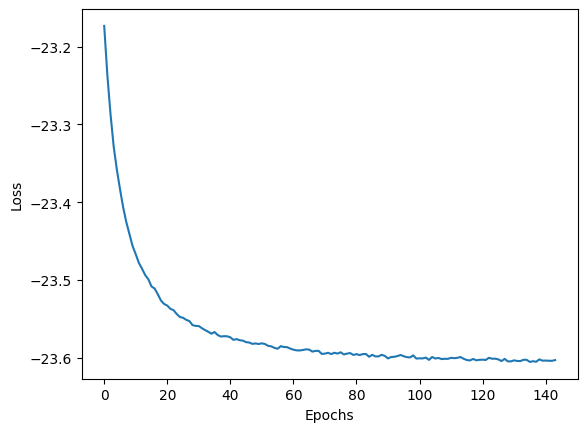

In [7]:
plt.plot(model_loss[6:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.yscale('log')
plt.plot()

In [16]:
HR, LR, LR_up = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [17]:
SR,_ = model.forward(LR, LR_up)

In [18]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

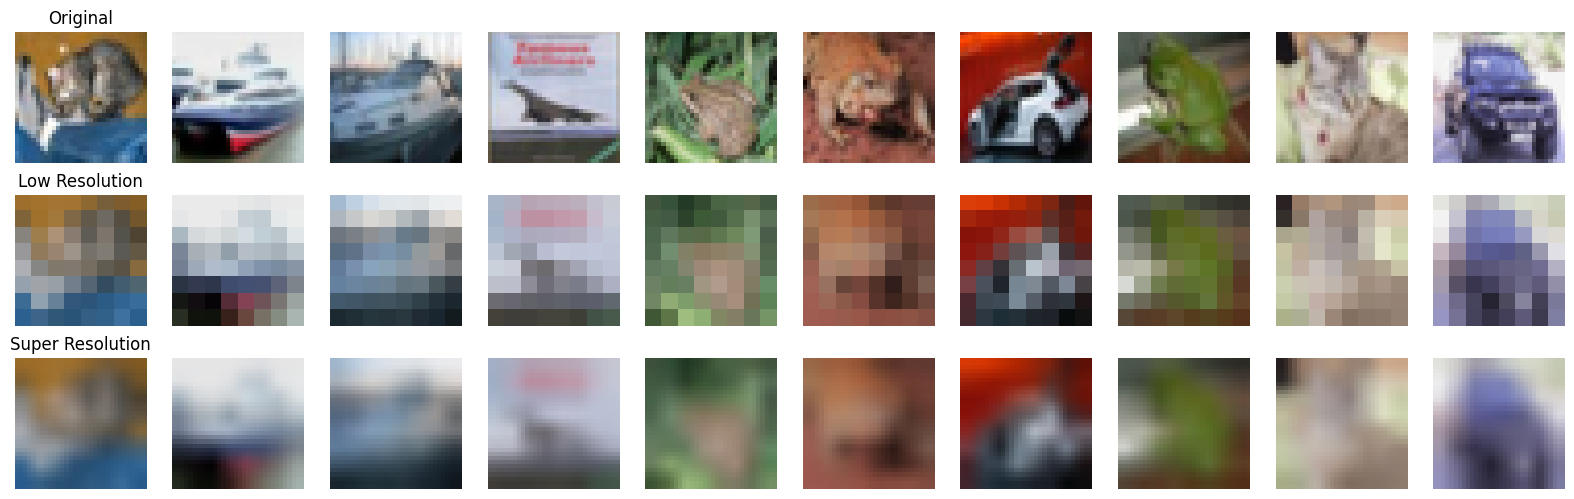

In [19]:
show_image(HR, LR, SR, 10)

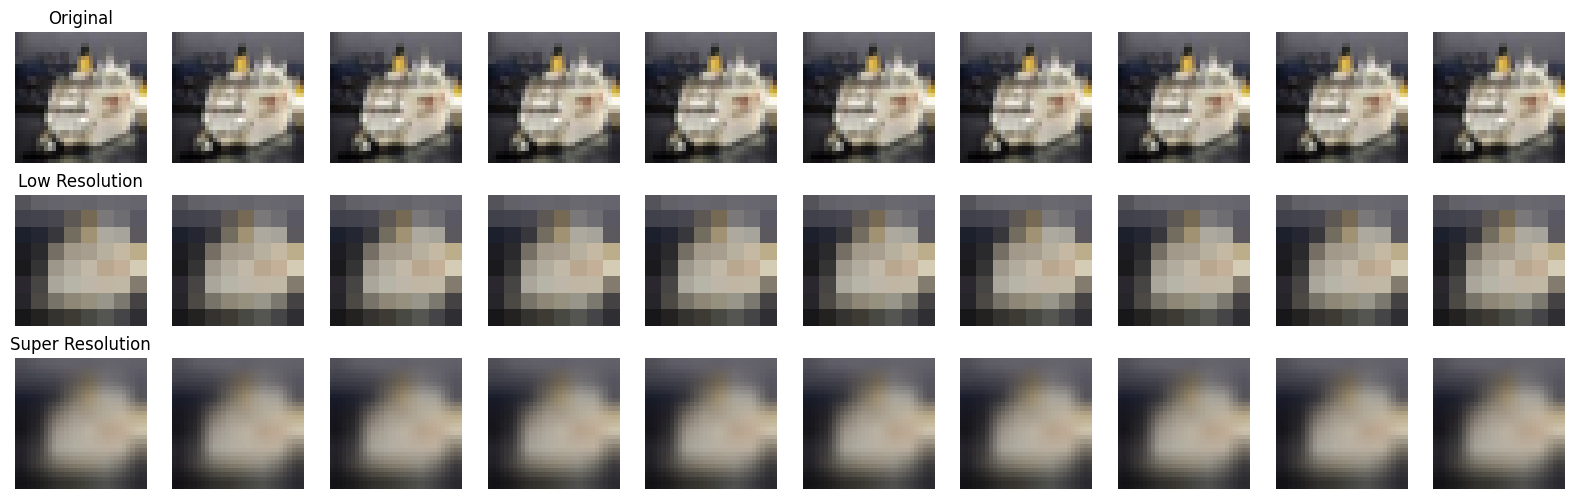

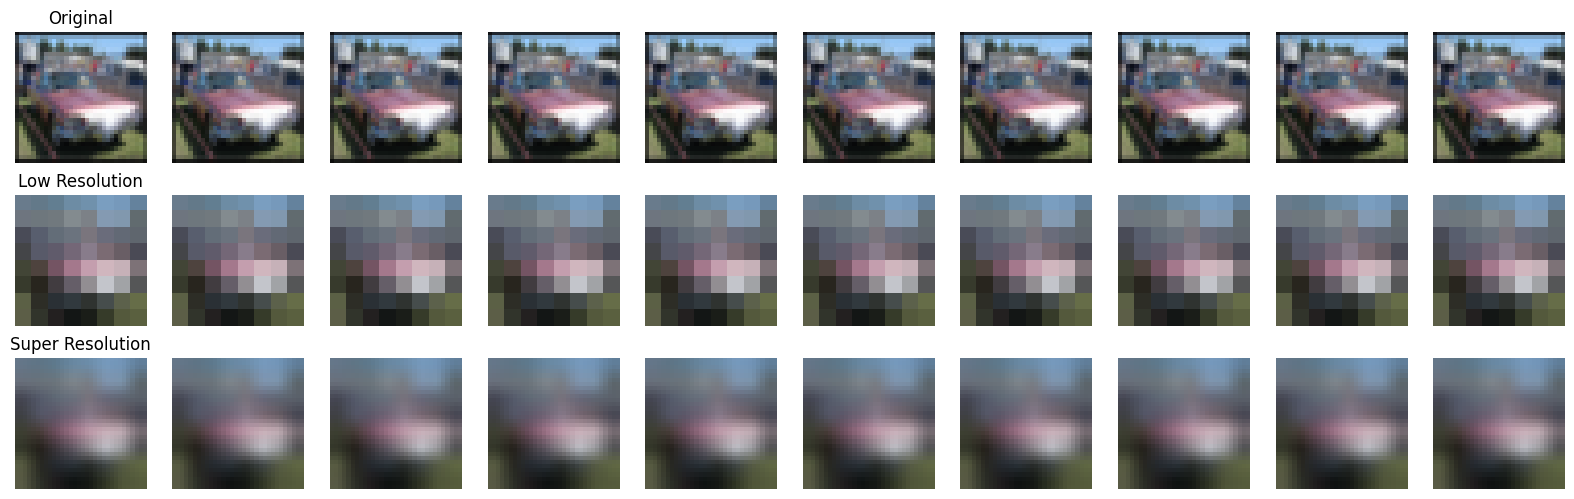

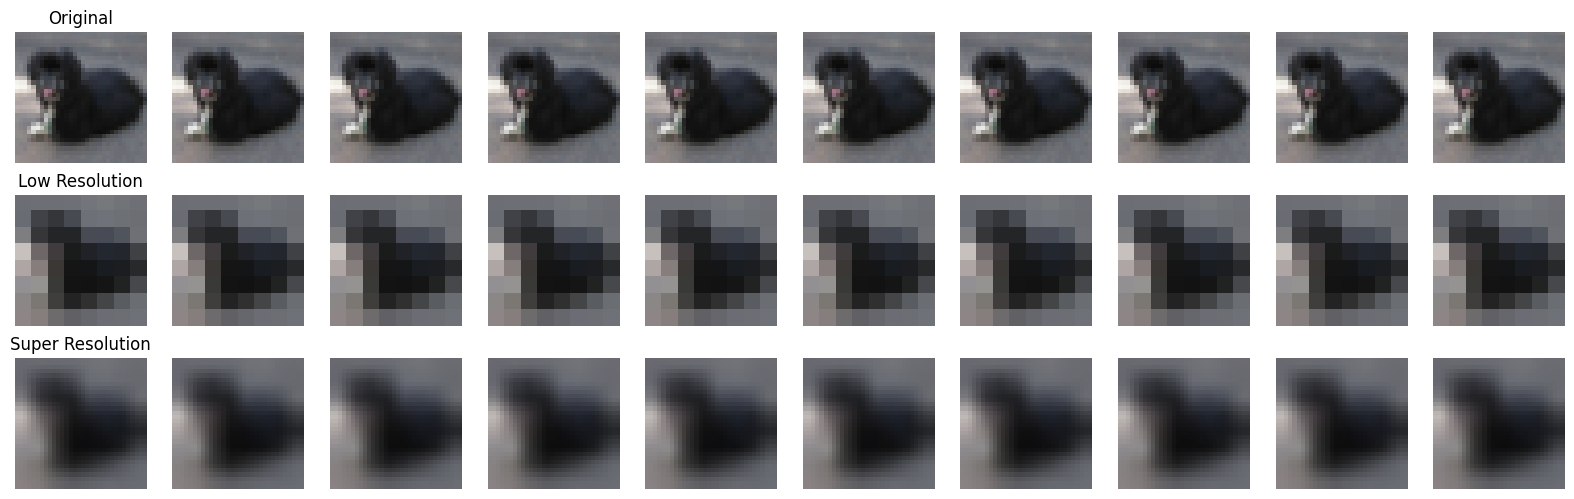

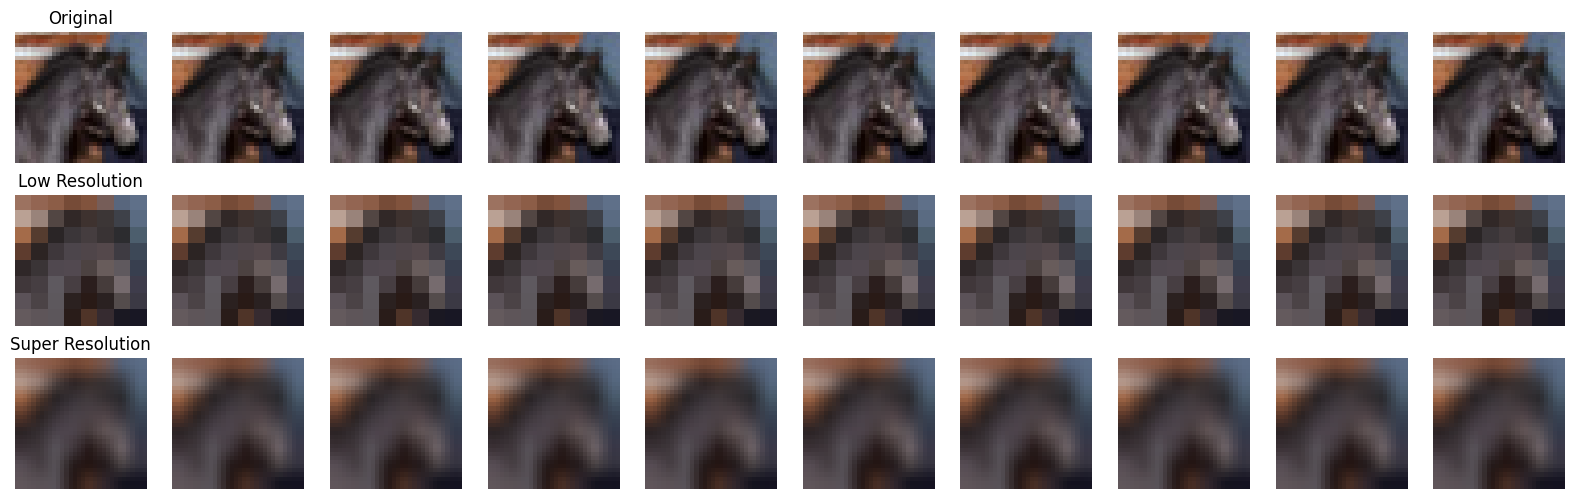

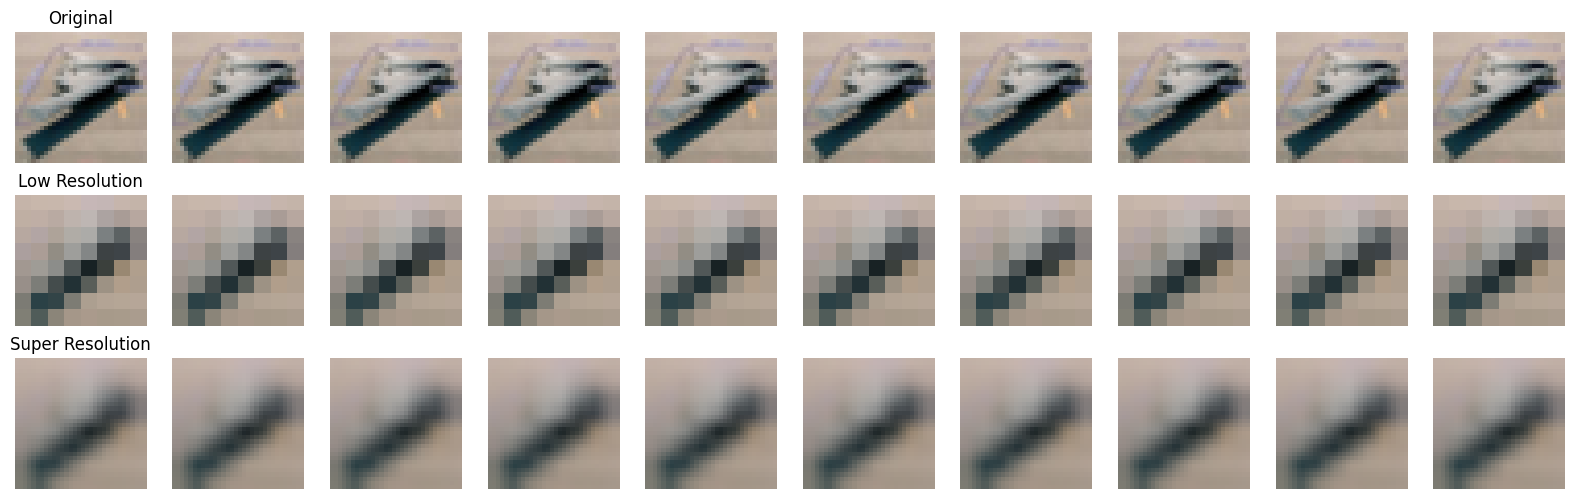

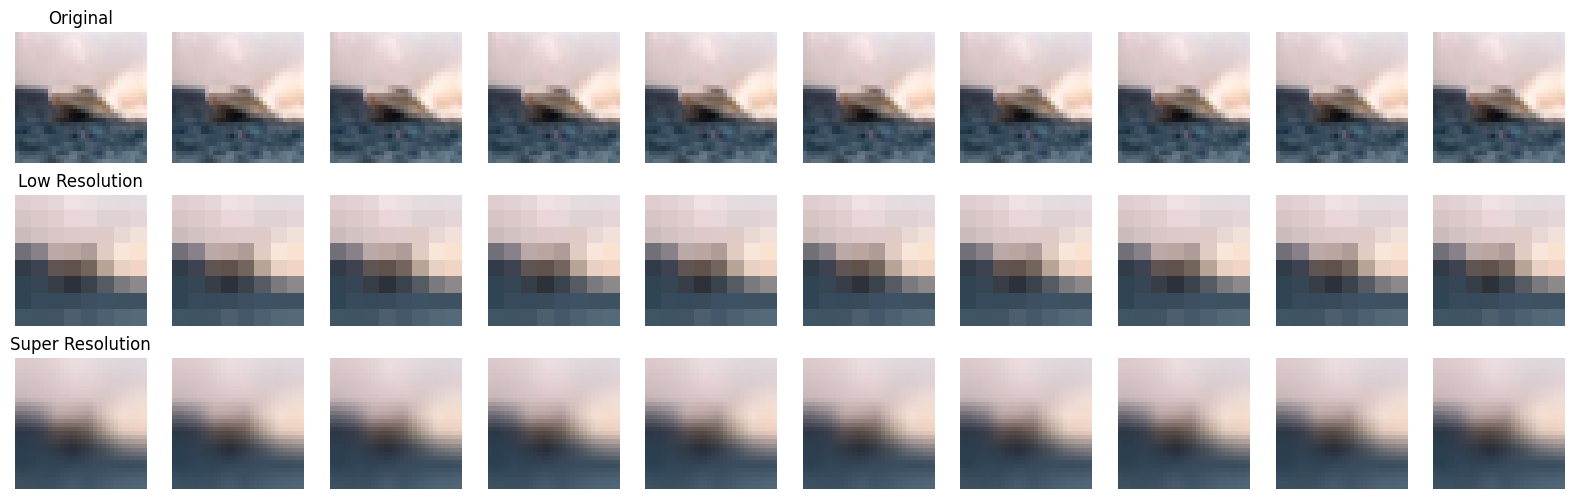

In [20]:
n_samp = 6
offset = 260

for i in range(offset, offset+n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

In [13]:
# save model
torch.save(model.state_dict(), path)

In [14]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [15]:
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("MSE:", mse_val)
print("Perceptual:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MSE: 0.011813560500741005
Perceptual: 5.6330766677856445
PSNR: 19.90538787841797
SSIM: 0.4913313686847687
LPIPS: 0.42470431327819824
BRISQUE: 61.95016098022461
PSNR Consistency: 27.8908634185791
MSE Diversity: 1.944830565925315e-06
LPIPS Diversity: 0.000554121602590385
